In [1]:
!pip install grad_cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad_cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=c7989b8f724ffcd32c16aa4e321769bce513a4836b1354049a006834caafc6b9
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad_cam


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import gdown
import zipfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPool2D, Activation, Input, Flatten, Rescaling, concatenate, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda
from tensorflow.keras import activations
from keras.datasets import cifar10
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist

# **Load MNIST Dataset**

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"shape of x_train: {x_train.shape}")

11490434/11490434 [==============================] - 1s 0us/step
shape of x_train: (60000, 28, 28)


# **Shuffle Datas**

In [5]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)

x_train = x_train[indices]
y_train = y_train[indices]

print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


# **Plot 5 images from Train and Test Datas**

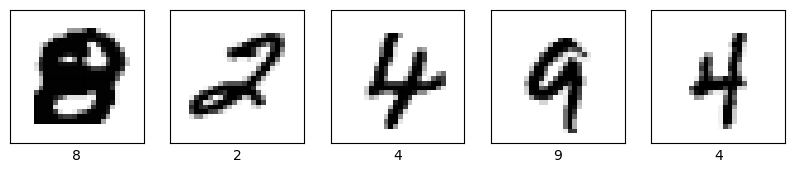

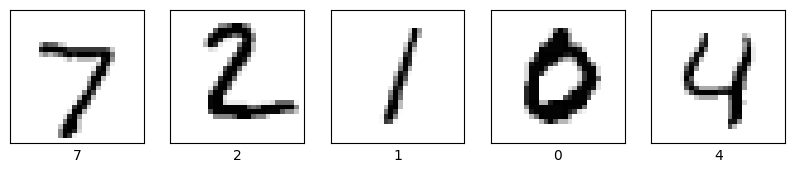

In [6]:
# plot the first 5 images in the training set
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(y_test[i])
plt.show()

# **Normalization**

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

# **Categorical**

In [8]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# **Model**

In [10]:
model = keras.Sequential()
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(input_img)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_img, outputs=output)
model.summary()

model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=64)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          1846

In [ ]:
model.save('trained_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Add Grad-Com**

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

conv2d_5


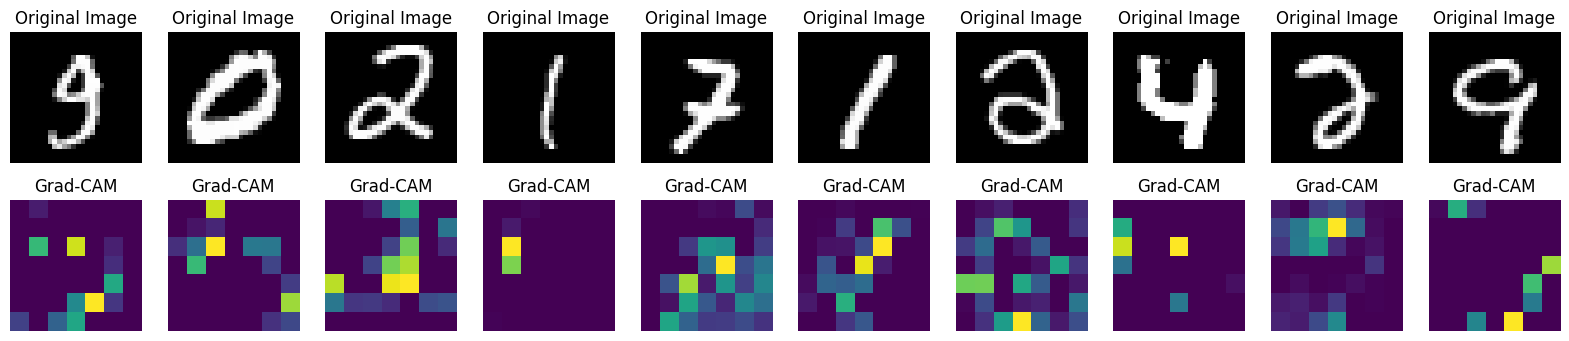

In [16]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

last_conv_layer_name = model.layers[-5].name
print(last_conv_layer_name)
for i in range(10):
    img_array = np.expand_dims(x_train[i+10], axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    axs[0, i].imshow(x_train[i+10].squeeze(), cmap='gray')
    axs[0, i].title.set_text('Original Image')
    axs[0, i].axis('off')

    axs[1, i].imshow(heatmap)
    axs[1, i].title.set_text('Grad-CAM')
    axs[1, i].axis('off')

plt.show()